<a href="https://colab.research.google.com/github/aida-wofford/Carmen/blob/main/Chisq3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from astropy import units as u
from astropy import coordinates as coords
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
from spectres import spectres
import math #for log10
import statistics #for mean() function
from astroquery.ned import Ned
from astroquery.irsa_dust import IrsaDust
from dust_extinction.parameter_averages import CCM89 # Importamos el modelo de Cardelli, Clayton & Mathis (1989) con A_V = 1 y R_V = 3.1 
from scipy.optimize import curve_fit
import scipy.optimize as opt

galaxies = ['NGC-1512','NGC-1566','M-51']# For building name of file with observation
clusters = ['YSC1','YSC2']# For building name of file with observation
galaxys = ['NGC 1512', 'NGC 1566', 'M51'] # For looking up galaxy in virtual observatory

def get_obs(igalaxy, icluster):
    path='../Data/Spectra/Updated_combined_spectra/'+galaxies[igalaxy]+'-'+clusters[icluster]+'_ssp_up_maskedSpectrum.txt'
    data=np.loadtxt(path)
    xcomb, ycomb, dycomb, maskcomb = np.transpose(data) #Observation corrected for MW reddening and flux in units of 10^-15 erg/s/cm2/A    
    ycomb=ycomb*1e-15
    dycomb=dycomb*1e-15
    return xcomb, ycomb, dycomb, maskcomb

age_str = ['1e6', '2e6', '3e6', '4e6', '5e6', '6e6', '7e6', '8e6', '9e6', '10e6']

def get_mod(it, iZ):
    t0 = .1e5 # Initial time step of models in Myr
    ages = [1e6, 2e6, 3e6, 4e6, 5e6, 6e6, 7e6, 8e6, 9e6, 10e6]# Model ages of interest in Myr
    metallicity=['v94_z020', 'v94_z040']    
    if iZ==0:
        path='../Models/v94_z020_10Myr/v94_z020_10Myr.ifaspec1'
    if iZ==1:
        path='../Models/v94_z040_10Myr/v94_z040_10Myr.ifaspec1'
    data=np.loadtxt(path, skiprows=6, delimiter="       ")
    time, wave, logL, norm = np.transpose(data) 
    good_indices = np.nonzero((time == ages[it] + t0) & (wave > 1150.) & (wave <=1700.))# Select good portion of spectrum
    x99=wave[good_indices]
    y99tmp=logL[good_indices]
    r99=norm[good_indices]
    y99=[]
    for ix in range(len(x99)):
        y99 = np.append(y99, 10**y99tmp[ix]) # Transform luminosity to linear value
    return x99, y99, r99

def get_ebvmw(galaxy):
  #Have the `coords` module automatically look up the coordinates from the name of the source 
    pos = coords.SkyCoord.from_name(galaxy)
    table = IrsaDust.get_extinction_table(pos)

    A_B = table['A_SandF'][table['Filter_name'] == 'CTIO B'] # extinción Galáctica en la banda B
    A_V = table['A_SandF'][table['Filter_name'] == 'CTIO V'] # extinción Galáctica en la banda V
    ebvmw = A_B - A_V # exceso de color E(B-V) de la Vía Láctea (Milky Way)

  # Definimos el modelo de enrojecimiento debido al polvo
    mwext = CCM89(Rv=3.1)
    return ebvmw, mwext

def deredden(x, y, dy, ebv, ext):
    x_units = x * u.AA # longitud de onda
    y_units = y * u.Unit('erg cm-2 s-1 AA-1') # flujo
    dy_units = dy * u.Unit('erg cm-2 s-1 AA-1') # error en el flujo
    ydered_units = y_units / ext.extinguish(1/x_units.to(u.micron), Ebv=ebv)  #flujo corregido por extinción
    dydered_units = dy_units / ext.extinguish(1/x_units.to(u.micron), Ebv=ebv)
    ydered = ydered_units.value
    dydered = dy_units.value
    return ydered, dydered

def get_z(target):
    result_table = Ned.query_object(target)
    z = result_table['Redshift'][0]
    #print('z=',z)
    return z

def zcorr(x, target):
    z = get_z(target)
    xrest = x / (1 + z) #Corrección por corrimiento al rojo de la galaxia que se está moviendo radialmente respecto al observador.
    return xrest, z

xlo=1263.
xhi=1645.
#xhi=1565.
xhi=1645.
dx=2.

def find_beta(x, y, dy, xlo, xhi):   
    good_indices = np.nonzero((abs(x-xlo) <= dx))
    xgood=x[good_indices]
    ygood=y[good_indices]#np.array(ymerged)[good_indices]
    y1=math.log10(statistics.mean(ygood))
    good_indices = np.nonzero((abs(x-xhi) <= dx))
    xgood=x[good_indices]
    ygood=y[good_indices]#np.array(ymerged)[good_indices]
    y2=math.log10(statistics.mean(ygood))
    x1 = math.log10(find_nearest(x, xlo))
    x2 = math.log10(find_nearest(x, xhi))
    beta=-(y1-y2)/(x1-x2)    
    return beta

def find_ebvi(x, y, dy, beta, xlo, xhi):
    ebvi=0.
    for iebv in range(190):#num. ebv pts, print((2-0.1)/0.01)=190
        if beta <= 2.59:
            ydered, dydered = deredden(x, y, dy, ebvi, extmw)
            ebvi = ebvi + 0.01
            good_indices = np.nonzero((abs(x-xlo) <= dx))
            xgood1=x[good_indices]
            ygood1=ydered[good_indices]#np.array(ymerged)[good_indices]
            y1=math.log10(statistics.mean(ygood1))
            good_indices = np.nonzero((abs(x-xhi) <= dx))
            xgood2=x[good_indices]
            ygood2=ydered[good_indices]#np.array(ymerged)[good_indices]
            y2=math.log10(statistics.mean(ygood2))
            x1 = math.log10(find_nearest(x, xlo))
            x2 = math.log10(find_nearest(x, xhi))
            beta=-(y1-y2)/(x1-x2)
            y0=(10**y1)/((10**x1)**(-beta))
            #print(y0)
            #print(ebvi, beta)
        else:
            iebv == 190
            ybeta = []
            yrec = []
            for j in range(len(x)):
                ybeta.append(y0*x[j]**(-beta))
                yrec.append(ydered[j]/ybeta[j])
            f1500=y0*1500.**(-beta)
    return ebvi, ydered, dydered, ybeta, yrec, f1500, beta, xgood1, xgood2, ygood1, ygood2
#S99 model beta 

def find_sf(x, y, f1500_obs, xlo, xhi):
    good_indices = np.nonzero((abs(x-xlo) <= dx))
    xgood=x[good_indices]
    ygood=y[good_indices]#np.array(ymerged)[good_indices]
    y1=math.log10(statistics.mean(ygood))
    good_indices = np.nonzero((abs(x-xhi) <= dx))
    xgood=x[good_indices]
    ygood=y[good_indices]#np.array(ymerged)[good_indices]
    y2=math.log10(statistics.mean(ygood))
    x1 = math.log10(find_nearest(x, xlo))
    x2 = math.log10(find_nearest(x, xhi))
    beta=-(y1-y2)/(x1-x2)
    y0=(10**y1)/((10**x1)**(-beta))
    f1500_mod=y0*1500.**(-beta)
    sf=f1500_mod/f1500_obs
    y99sf = []
    for i in range(len(x)):
        y99sf=np.append(y99sf, y[i]/sf)
    return y99sf
        
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def find_plt_lim(x, y, z):
    good_indices = np.nonzero(x > 1320.)
    ymin = min(y[good_indices])
    good_indices = np.nonzero(x < 1200.)
    ymax = max(y[good_indices])
    return ymin, ymax 

def chisqfunc(obs, err, mod):
    chisq = np.sum(((obs - mod)/err)**2)
    return chisq



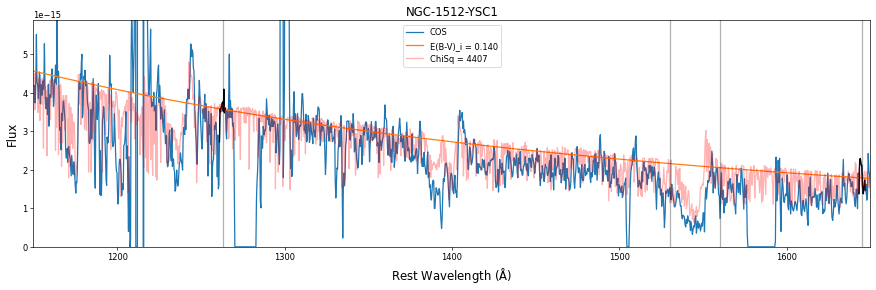

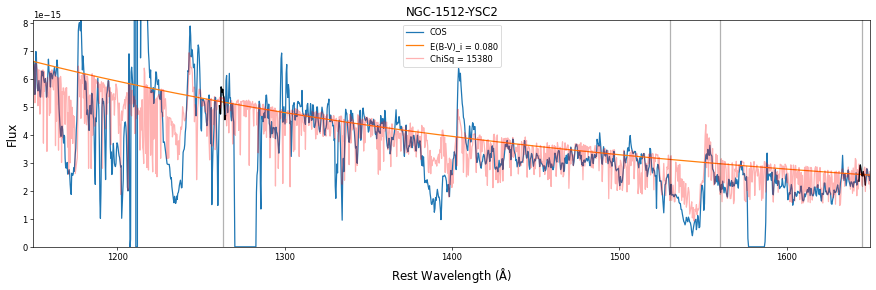

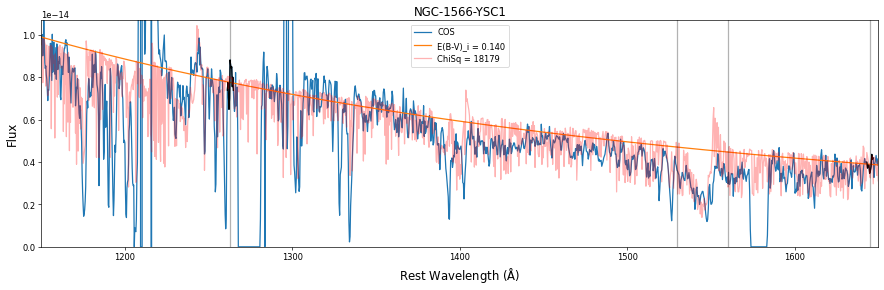

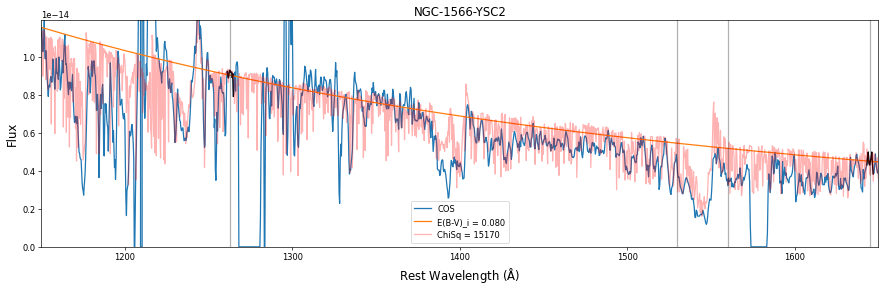

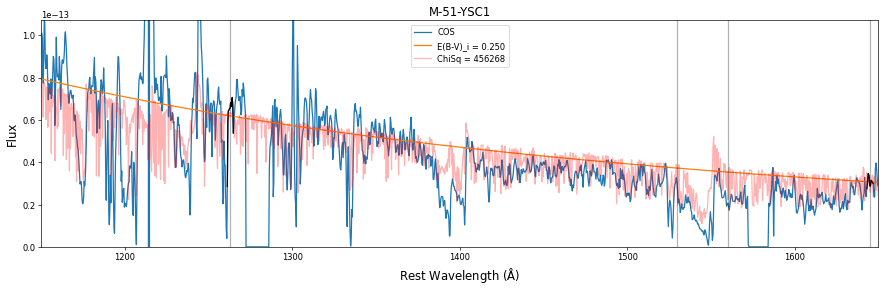

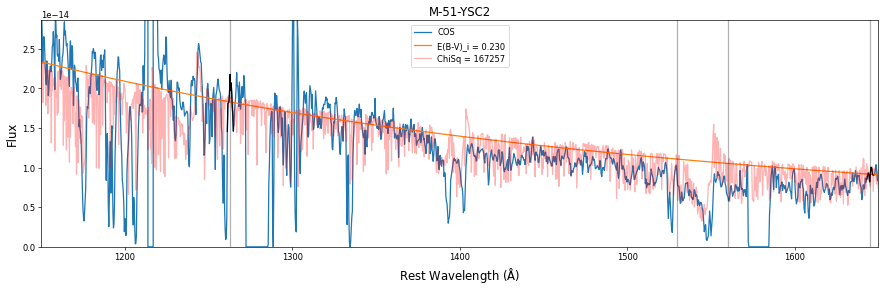

In [ ]:
iage=3
imetallicity=0
for igalaxy in range(3):
    for icluster in range(2):
        xcomb, ycomb, dycomb, maskcomb = get_obs(igalaxy, icluster)#Get observation
        x99, y99, r99 = get_mod(iage, imetallicity)#Get common array from model
        xrest, z = zcorr(xcomb, galaxys[igalaxy])#Correct for redshift
        yobs = spectres(x99, xrest, ycomb, fill=0.)# Use common array
        dyobs = spectres(x99, xrest, dycomb, fill=0.)# Use common array
        ebvmw, extmw = get_ebvmw(galaxys[igalaxy])#Get extmw for intrinsic correction
        beta = find_beta(x99, yobs, dyobs, xlo, xhi)#Before intrinsic correction
        ebvi, ydered, dydered, ybeta, yrec, f1500, beta, xgood1, xgood2, ygood1, ygood2 = find_ebvi(x99, yobs, dyobs, beta, xlo, xhi)
        y99sf = find_sf(x99, y99, f1500, xlo, xhi)
        fig = plt.subplots(figsize=(18,5), dpi=60)
        plt.title(galaxies[igalaxy]+'-'+clusters[icluster], fontsize=14)# Set plot title
        plt.xlim(1150,1650)# Set limits of horizontal axis
        ymin, ymax = find_plt_lim(x99, ydered, z)
        plt.ylim(ymin, ymax)# Set limits of vertical axis
        plt.xlabel(r'Rest Wavelength ($\rm{\AA}$)', fontsize=14)# Set label of horizontal axis
        plt.ylabel('Flux', fontsize=14)# Set label of vertical axis
        plt.plot(x99, ydered, label='COS')
        txt='E(B-V)_i = {b:.3f}'
        plt.plot(x99, ybeta, label=txt.format(b=ebvi))
        plt.plot(xgood1, ygood1, color='black')
        plt.plot(xgood2, ygood2, color='black')
        plt.axvline(x=xlo ,color="black",alpha=0.3,zorder=10)
        plt.axvline(x=xhi ,color="black",alpha=0.3,zorder=10)
        fit=np.nonzero((x99>=1530.) & (x99<=1560))
        plt.axvline(x=1530. ,color="black",alpha=0.3,zorder=10)
        plt.axvline(x=1560. ,color="black",alpha=0.3,zorder=10)
        chisq = chisqfunc(ydered[fit],dydered[fit],y99sf[fit])
        txt='ChiSq = {b:.0f}'
        plt.plot(x99, y99sf, color='red', alpha=.3, label=txt.format(b=chisq))
        plt.legend()
